In [ ]:
import pandas as pd
import numpy as np
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3'


In [ ]:
second_round_trials = pd.read_csv('./top_twenty_patients_checked_synthetic_round2.csv')

In [ ]:
first_round_patients = pd.read_csv('./top_ten_cohorts_checked_synthetic.csv')
first_round_trials = pd.read_csv('./top_twenty_patients_checked_synthetic.csv')
second_round_patients = pd.read_csv('./top_ten_cohorts_checked_synthetic_round2.csv')
second_round_trials = pd.read_csv('./top_twenty_patients_checked_synthetic_round2.csv')


In [ ]:

patient = pd.concat([first_round_patients, second_round_patients], ignore_index=True, axis=0)
patient.info()

In [ ]:

space = pd.concat([first_round_trials, second_round_trials], axis=0, ignore_index=True).rename(columns={'this_patient':'patient_summary', 'space_summary':'this_space'})
space.info()

In [ ]:
dataset = pd.concat([patient, space], axis=0, ignore_index=True).groupby(['patient_summary','this_space']).first().reset_index()
dataset = dataset[['split','patient_summary','this_space','eligibility_result']]
dataset.info()

In [ ]:
dataset.eligibility_result.value_counts()

In [ ]:
dataset['eligibility_result'] = dataset.eligibility_result.astype(int)

In [ ]:
from transformers import AutoTokenizer

In [ ]:
dataset.info()

In [ ]:
dataset['pt_trial_pair'] = dataset['this_space'] + "\nNow here is the patient summary:" + dataset['patient_summary']

In [ ]:
dataset=dataset[dataset.split != 'test']
dataset = dataset[['pt_trial_pair', 'eligibility_result', 'split']].rename(columns={'pt_trial_pair':'text','eligibility_result':'label'})

In [ ]:
from datasets import Dataset, DatasetDict

In [ ]:
train_ds = Dataset.from_pandas(dataset[dataset.split=='train'])
valid_ds = Dataset.from_pandas(dataset[dataset.split.str.contains('valid')])

In [ ]:
data_dict = DatasetDict({"train":train_ds, "valid":valid_ds})

In [ ]:
data_dict

In [ ]:
data_dict['train'][0]

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("roberta-large")


In [ ]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, max_length=512)

In [ ]:
tokenized_data = data_dict.map(preprocess_function, batched=True)

In [ ]:
from transformers import DataCollatorWithPadding

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    #predictions = np.argmax(predictions, axis=1)
    return auroc.compute(predictions=predictions, references=labels)

In [ ]:
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    "roberta-large", num_labels=2, id2label=id2label, label2id=label2id
)

In [ ]:
training_args = TrainingArguments(
    output_dir="roberta_checker_training",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    #evaluation_strategy="epoch",
    save_strategy="epoch",
    #load_best_model_at_end=True,
    push_to_hub=False,
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data["train"],
    #eval_dataset=tokenized_data["valid"],
    tokenizer=tokenizer,
    data_collator=data_collator
    #compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

In [ ]:
predictions = trainer.predict(tokenized_data['valid'])

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
roc_auc_score(predictions[1], predictions[0][:,1])

In [ ]:
#model.save_pretrained('roberta-checker')

In [ ]:
trainer.save_model('roberta-checker')

In [ ]:
# eval just on round 1 generated data
import pandas as pd
import numpy as np
from transformers import AutoModelForSequenceClassification, Trainer
round2_patient = pd.read_csv('top_ten_cohorts_checked_round2.csv')
round2_space = pd.read_csv('top_twenty_patients_checked_round2.csv').rename(columns={'this_patient':'patient_summary', 'space_summary':'this_space'})

dataset = pd.concat([round2_space, round2_patient], axis=0, ignore_index=True)




In [ ]:
dataset['eligibility_result'] = dataset.eligibility_result.astype(int)

In [ ]:
from transformers import AutoTokenizer

In [ ]:
dataset.info()

In [ ]:
dataset['pt_trial_pair'] = dataset['this_space'] + "\nNow here is the patient summary:" + dataset['patient_summary']

In [ ]:
dataset.split.value_counts()

In [ ]:
dataset=dataset[dataset.split.str.contains('valid')]
dataset = dataset[['pt_trial_pair', 'eligibility_result', 'split']].rename(columns={'pt_trial_pair':'text','eligibility_result':'label'})

In [ ]:
from datasets import Dataset, DatasetDict

In [ ]:
#train_ds = Dataset.from_pandas(dataset[dataset.split=='train'])
valid_ds = Dataset.from_pandas(dataset[dataset.split.str.contains('valid')])

In [ ]:
data_dict = DatasetDict({"valid":valid_ds})

In [ ]:
data_dict

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('roberta-large')
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, max_length=512)

In [ ]:
tokenized_data = data_dict.map(preprocess_function, batched=True)

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained('roberta-checker')

In [ ]:
from transformers import pipeline
pipe = pipeline('text-classification', './roberta-checker', tokenizer=tokenizer, truncation=True, padding='max_length', max_length=512, device='cuda') 
predictions = pipe(dataset[dataset.split.str.contains('valid')].text.tolist())

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
predictions_frame = pd.DataFrame(predictions)
predictions_frame['score'] = np.where(predictions_frame.label=='NEGATIVE', 1 - predictions_frame.score, predictions_frame.score)

In [51]:
# checker results on round 1 generated data ('round 2 data')
roc_auc_score(dataset.label, predictions_frame.score)

0.8975794567785704

AUC 0.8975794567785704
Outcome probability: 0.7107222222222223
Average precision score: 0.95
Best F1: 0.9020847444870926


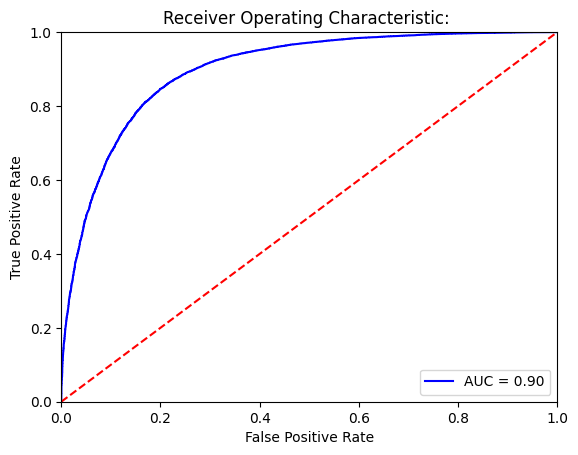

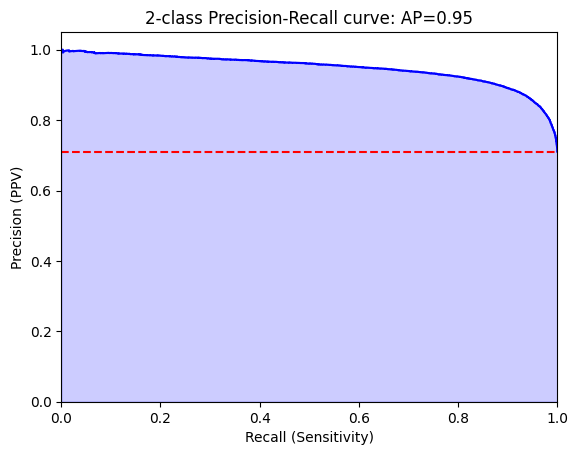

Threshold for best F1:
-0.5866777437495557
Confusion matrix at best F1 thresh:
Confusion matrix, without normalization
[[10236  5385]
 [ 2421 35958]]


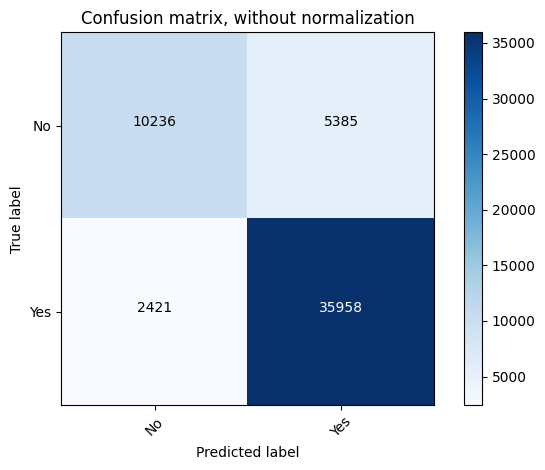

Metrics at best F1 thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.81      0.66      0.72     15621
         Yes       0.87      0.94      0.90     38379

    accuracy                           0.86     54000
   macro avg       0.84      0.80      0.81     54000
weighted avg       0.85      0.86      0.85     54000

Confusion matrix at 0.5 thresh:
Confusion matrix, without normalization
[[11807  3814]
 [ 4462 33917]]


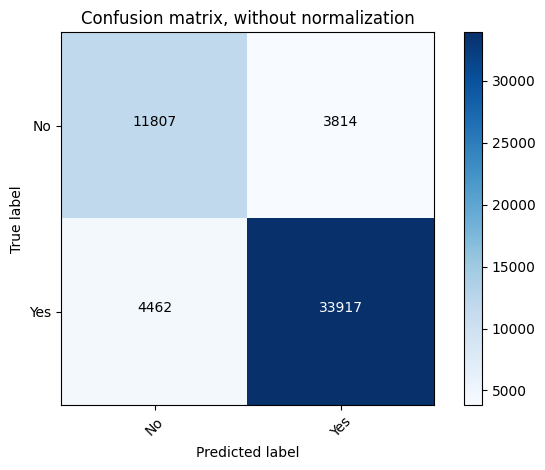

Metrics at 0.5 thresh thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.73      0.76      0.74     15621
         Yes       0.90      0.88      0.89     38379

    accuracy                           0.85     54000
   macro avg       0.81      0.82      0.82     54000
weighted avg       0.85      0.85      0.85     54000



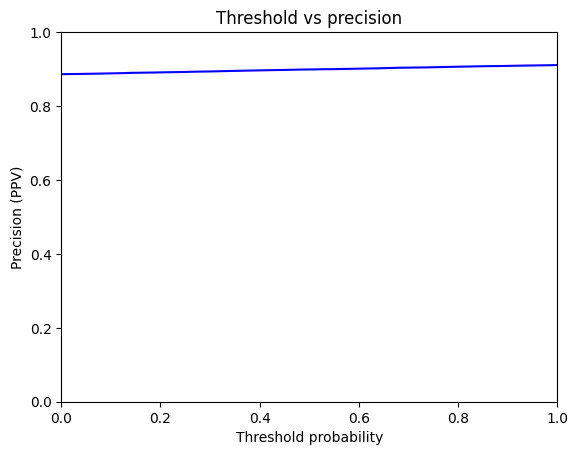

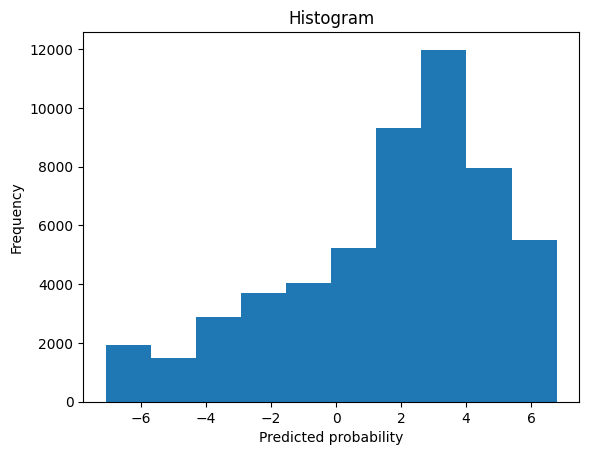

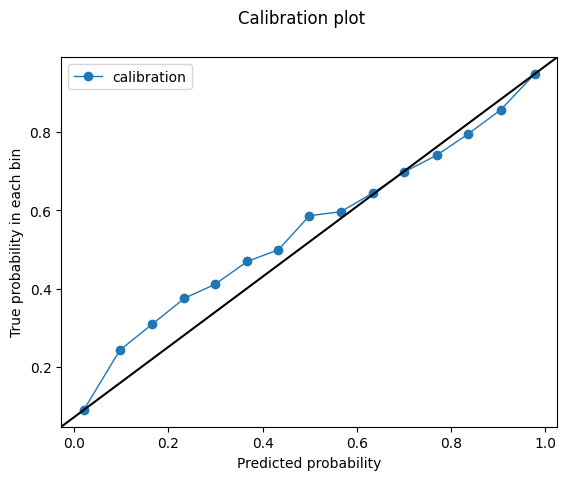

-0.5866777437495557

In [52]:
from utils_102023 import eval_model
predictions_frame['logit_score'] = np.log(predictions_frame.score / (1 - predictions_frame.score))
eval_model(predictions_frame.logit_score, dataset.label, graph=True)

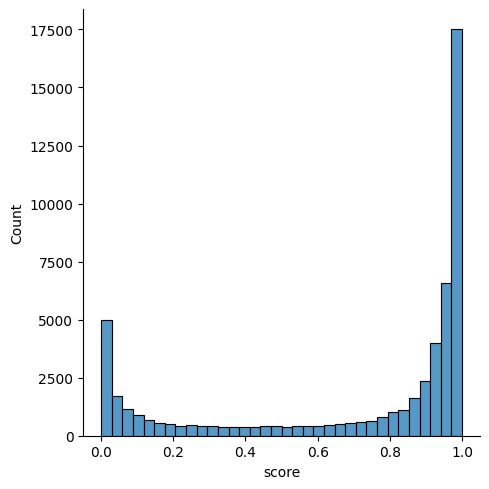

In [53]:
import seaborn as sns
sns.displot(predictions_frame.score)